In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
%cd drive/MyDrive/Dyploma/CVLab3/

/content/drive/MyDrive/Dyploma/CVLab3


In [1]:
import os 
import random

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator 
from keras.utils.np_utils import to_categorical 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.datasets import fashion_mnist

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255 
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255 

print('Training', x_train.shape, x_train.max()) 
print('Testing', x_test.shape, x_test.max()) 

4431872/4422102 [==============================] - 0s 0us/step
Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [3]:
# reorganize by groups 
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)] 
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)] 

print('train groups:', [x.shape[0] for x in train_groups]) 
print('test groups:', [x.shape[0] for x in test_groups]) 


train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [4]:
def create_pairs(x, digit_indices, labels_num):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(labels_num)]) - 1
    for d in range(labels_num):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, labels_num)
            dn = (d + inc) % labels_num
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def make_pair_dataset(images, labels, labels_num):
    digit_indices = [np.where(labels == i)[0] for i in range(labels_num)]
    pairs, y = create_pairs(images, digit_indices, labels_num)
    return pairs, y

In [5]:
train_pairs, train_lables = make_pair_dataset(x_train, y_train, len(np.unique(y_train)))
test_pairs, test_lables = make_pair_dataset(x_test, y_test, len(np.unique(y_test)))

In [6]:
len(np.unique(y_train))

10

# XCeption

In [7]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras import Model 


In [8]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

In [9]:
def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)
  
    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    return x

def middle_flow(tensor, n=8):
    for _ in range(n):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)

        tensor = Add()([tensor, x])

    return tensor

def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
#     x = Dense(units=1000, activation='softmax')(x)

    return x

In [10]:
def XCeption(img_shape: list, n_midl: int):
    input = Input(shape=img_shape)

    x = entry_flow(input)
    x = middle_flow(x, n_midl)
    output = exit_flow(x)

    model = Model(input, output, name='XCeption')
    return model


In [11]:
XCeption([30, 30, 1], 1).summary()

Model: "XCeption"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 15, 15, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 15, 15, 32)   0           ['batch_normalization[0][0

# Define Siamese

In [27]:
img_shape =  tuple(np.concatenate((x_test.shape[1:], [1])))

In [28]:
feature_model = XCeption(img_shape[:-1], 1)

In [29]:
img_a_in = tf.keras.layers.Input(shape = img_shape, name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = img_shape, name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = tf.keras.layers.concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)

In [30]:
siamese_model = tf.keras.Model(inputs = [img_a_in, img_b_in], outputs=[combined_features], name = 'Siamese')
siamese_model.summary()


Model: "Siamese"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1,   0           []                               
                                1)]                                                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1,   0           []                               
                                1)]                                                               
                                                                                                  
 XCeption (Functional)          (None, 2048)         9532496     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']     

# Training

In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                         loss='binary_crossentropy',
                         metrics=['mae'])

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    "similarity_model/",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)

In [34]:
# train_pairs, train_lables
# test_pairs, test_lables

history = siamese_model.fit([train_pairs[:,0], train_pairs[:, 1]], train_lables, epochs=50, batch_size=64, 
                    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_lables), callbacks=[early_stopping, save_model, reduce_lr])

Epoch 1/50
1875/1875 [==============================] - ETA: 0s - loss: 0.3327 - mae: 0.2271

INFO:tensorflow:Assets written to: similarity_model/assets


INFO:tensorflow:Assets written to: similarity_model/assets


1875/1875 [==============================] - 89s 45ms/step - loss: 0.3327 - mae: 0.2271 - val_loss: 0.2447 - val_mae: 0.1540 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - ETA: 0s - loss: 0.2077 - mae: 0.1297

INFO:tensorflow:Assets written to: similarity_model/assets


INFO:tensorflow:Assets written to: similarity_model/assets


1875/1875 [==============================] - 85s 45ms/step - loss: 0.2077 - mae: 0.1297 - val_loss: 0.1954 - val_mae: 0.1059 - lr: 0.0010
Epoch 3/50
1875/1875 [==============================] - ETA: 0s - loss: 0.1711 - mae: 0.1043

INFO:tensorflow:Assets written to: similarity_model/assets


INFO:tensorflow:Assets written to: similarity_model/assets


1875/1875 [==============================] - 85s 45ms/step - loss: 0.1711 - mae: 0.1043 - val_loss: 0.1788 - val_mae: 0.0990 - lr: 0.0010
Epoch 4/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1497 - mae: 0.0902 - val_loss: 0.1823 - val_mae: 0.0925 - lr: 0.0010
Epoch 5/50
1875/1875 [==============================] - ETA: 0s - loss: 0.1339 - mae: 0.0797

INFO:tensorflow:Assets written to: similarity_model/assets


INFO:tensorflow:Assets written to: similarity_model/assets


1875/1875 [==============================] - 85s 45ms/step - loss: 0.1339 - mae: 0.0797 - val_loss: 0.1605 - val_mae: 0.0843 - lr: 0.0010
Epoch 6/50
1875/1875 [==============================] - ETA: 0s - loss: 0.1214 - mae: 0.0716

INFO:tensorflow:Assets written to: similarity_model/assets


INFO:tensorflow:Assets written to: similarity_model/assets


1875/1875 [==============================] - 85s 45ms/step - loss: 0.1214 - mae: 0.0716 - val_loss: 0.1490 - val_mae: 0.0764 - lr: 0.0010
Epoch 7/50
1875/1875 [==============================] - 74s 39ms/step - loss: 0.1091 - mae: 0.0640 - val_loss: 0.1538 - val_mae: 0.0794 - lr: 0.0010
Epoch 8/50
1875/1875 [==============================] - 74s 39ms/step - loss: 0.0981 - mae: 0.0569 - val_loss: 0.1579 - val_mae: 0.0769 - lr: 0.0010
Epoch 9/50
1875/1875 [==============================] - 74s 39ms/step - loss: 0.0895 - mae: 0.0517 - val_loss: 0.1514 - val_mae: 0.0684 - lr: 0.0010


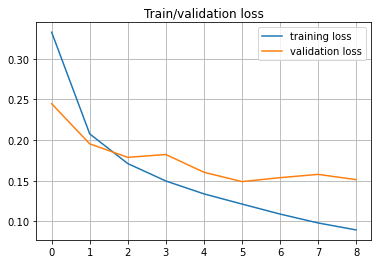

In [35]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.title('Train/validation loss')
    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')
    plt.grid()
    plt.legend()
    plt.show()

plot_history(history)

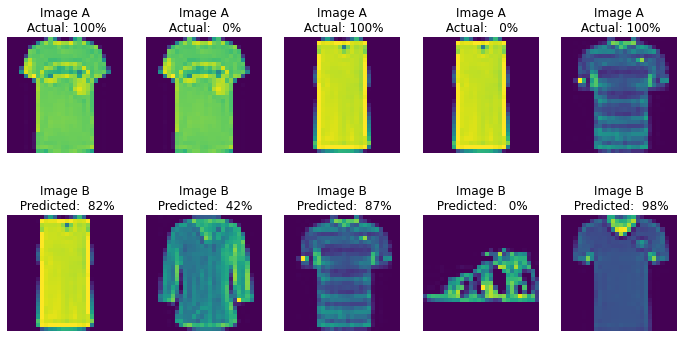

In [47]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim  = test_pairs[:nb_examples, 0], test_pairs[:nb_examples, 1], test_lables[:nb_examples]

    pred_sim = siamese_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        c_a, c_b = np.squeeze(c_a), np.squeeze(c_b)

        ax1.imshow(np.squeeze(c_a))
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b)
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
    # a completely untrained model
_ = show_model_output(5)

# Find Similar

In [56]:
def show_alike(original, batch, n=3):
    pv_a, pv_b = np.reshape([original]*len(batch), (len(batch), 28,28)), np.reshape(batch, (len(batch), 28,28))
    pred_sim = siamese_model.predict([pv_a, pv_b]).ravel()
    indxs = np.argsort(pred_sim)[::-1][:n]
    
    fig, m_axs = plt.subplots(2, n, figsize = (12, 6))
    i = 0
    for c_a, (ax1, ax2) in zip(pv_a[:n], m_axs.T):
        
        ax1.imshow(c_a)
        ax1.set_title('Input image\n')
        ax1.axis('off')
        ax2.imshow(pv_b[indxs[i]])
        ax2.set_title('Similar\n Predicted: %3.0f%%' % (100*pred_sim[indxs[i]]))
        ax2.axis('off')
        i += 1


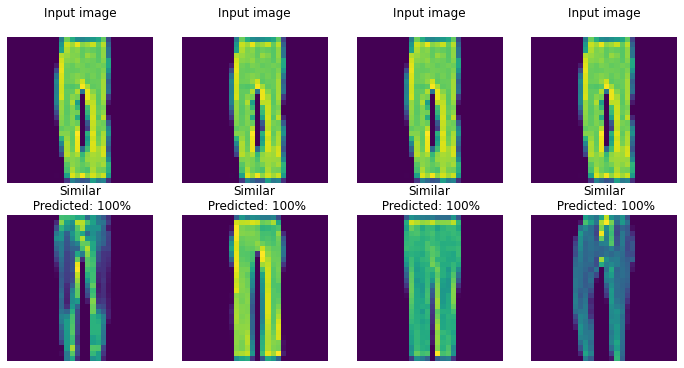

In [57]:
show_alike(x_test[47], x_test[50:100], 4)

# t-SNE

In [59]:
from sklearn.manifold import TSNE

In [58]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=64)

157/157 [==============================] - 1s 5ms/step


In [60]:
%%time
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 7.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.137175
[t-SNE] Computed conditional probabilities in 0.367s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 63.0271454, gradient norm = 0.0050018 (50 iterations in 2.337s)
[t-SNE] Iteration 100: error = 63.9361267, gradient norm = 0.0034190 (50 iterations in 2.186s)
[t-SNE] Iteration 150: error = 64.0682373, gradient norm = 0.0024681 (50 iterations in 2.182s)
[t-SNE] Iteration 200: error = 64.2365723, gradient norm = 0.0010450 (50 iterations in 2.165s)
[t-SNE] Iteration 250: error = 64.3691406, gradient norm = 0.0006966 (50 iterations in 2.590s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.369141
[t-SNE] Iteration 300: error = 1.7833382, gradient norm = 0.0008973 (50 iterations in 3.701s)
[t-SNE] Iteration 350: error = 1.5794581, gradient norm = 0.0004139 (50 iterations in 4.343s)
[t-SNE] Iteration 400: error = 1.4651628, gradient norm = 0.0002874 (50 iterations in 3.427s)
[t-SNE] Iteration 450: error = 1.3742971, gradient norm = 0.0002204 (50 iterations in 2.200s)
[t-SNE] Iteration 500: error = 1.3001150, gradient norm = 0.0001727 (50 

In [66]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))


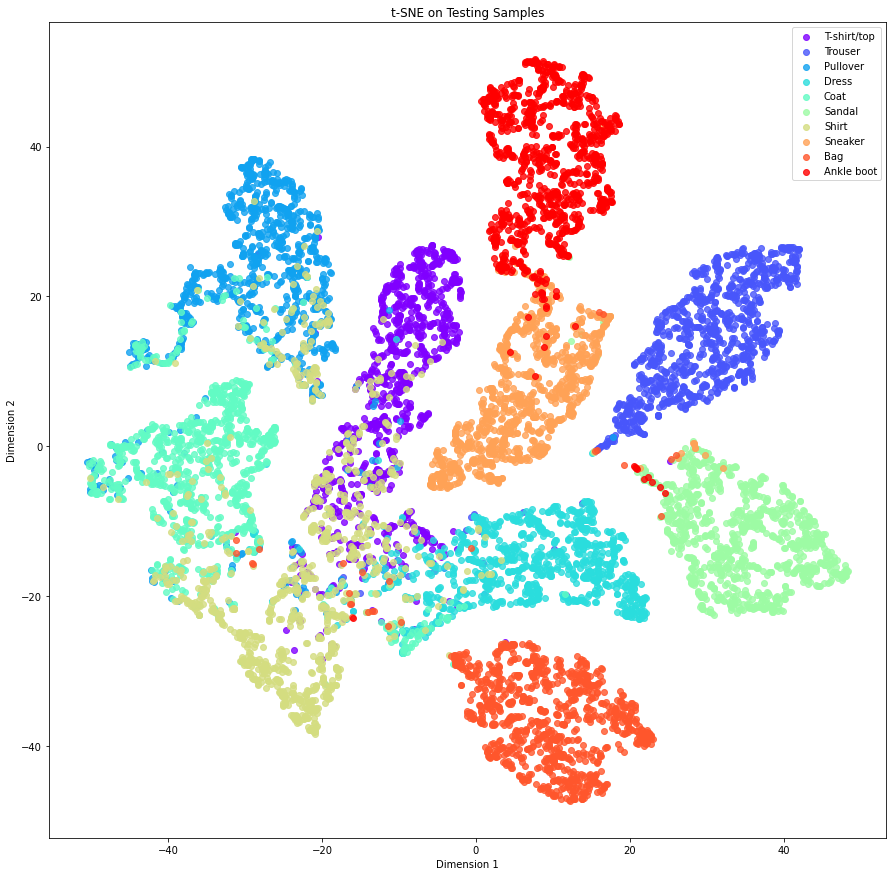

In [67]:
plt.figure(figsize=(15, 15))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
    tsne_features[np.where(y_test == c_group), 1],
    marker='o',
    color=c_color,
    linewidth='1',
    alpha=0.8,
    label=c_label)
  
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)